<a href="https://colab.research.google.com/github/bandofpv/USNA-Robotics-Courses/blob/main/EW442/Project_2_Web_Scraping_Uncooperative_Sites.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EW 442: Data Science and AI**

## **Project 2: Web Scraping Uncooperative Sites (Google Colab Version)**

![][image1]

[image1]: <>

Citations (used doc website search bar for specific methods/functions:
* [pandas](https://pandas.pydata.org/docs/) documentation
* [matplotlib](https://matplotlib.org/stable/index.html) documentation
* Also used class slides and assignment document

# **Goals**

* **Scrape** raw HTML using Python and `requests`.
* **Format** data from complex, multi-layered HTML tables.
* **Clean** "noisy" strings (footnotes, symbols) into actionable numeric data.
* **Perform** exploratory data analysis (EDA) using `pandas`.

## **Part 1: Environment Setup & Data Collection**

In Google Colab, we do not need to manage local environments, but we must handle web request restrictions carefully.

1. **Create a New Notebook:** Name it `EW442_Project2_Lastname`.
2. **Setup & Imports:** Copy and run the following code block to import necessary libraries and configure the network request.
   * *Note:* Wikipedia often blocks requests from cloud servers (like Colab). We use the `requests` library with a user-agent header to legitimately access the data.

In [1]:
import pandas as pd
import requests

# Target URL
url = 'https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population'

# Set header to mimic a browser and bypass 403 Forbidden errors
header = {"User-Agent": "Mozilla/5.0"}

# Fetch the raw HTML content
response = requests.get(url, headers=header)

# Parse tables using Pandas
# Note: We pass response.text, not the URL directly
tables = pd.read_html(response.text)

# Get data type
print(type(tables))

<class 'list'>


/tmp/ipython-input-352576726.py:15: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text)


3. **Question:** In a text cell, answer: What specific data type is returned by `pd.read_html`?

> **Answer:**
>A list
>

## **Part 2: Finding the Target Table**

We need the primary census table, but web pages often contain hidden layout tables. You must identify the correct one explicitly.

1. **Inspect the Source:** Open the [Wikipedia Page](https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population) in Chrome. Right-click the main table and select `Inspect`.
2. **Identify Table Index:** In the Chrome Developer Tools, click the **Console** tab. Paste the following JavaScript code and press Enter:
    `var i = 1; [].forEach.call(document.querySelectorAll('table'), function(x) { console.log(i++, x); });`
    This script lists every table on the page sequentially. Hover over the results in the console to highlight them on the page.
   * **Question:** Looking at the console output, what is the **first** table on the page? (Describe it briefly).
   * **Task:** Identify the index number of the main "United States cities by population" table.

> **Answer:**
>The first table is a table introducing the Wikipedia article. It’s titled “Population tables of U.S. cities” and has several hyperlinks.
>

In [2]:
# 3. Extract the Table
# #TODO: Replace 'x' with the integer index you identified
census_table = tables[2]

# Verify extraction
census_table.head()

Municipality  ST 2024 estimate 2020 census  Change 2020 land area          \
  Municipality  ST 2024 estimate 2020 census  Change            mi2     km2   
0  New York[c]  NY       8478072     8804190  −3.70%          300.5   778.3   
1  Los Angeles  CA       3878704     3898747  −0.51%          469.5  1216.0   
2      Chicago  IL       2721308     2746388  −0.91%          227.7   589.7   
3      Houston  TX       2390125     2304580  +3.71%          640.4  1658.6   
4      Phoenix  AZ       1673164     1608139  +4.04%          518.0  1341.6   

  2020 density                                      Location  
         / mi2  / km2                               Location  
0        29298  11312    40°40′N 73°56′W﻿ / ﻿40.66°N 73.94°W  
1         8304   3206  34°01′N 118°25′W﻿ / ﻿34.02°N 118.41°W  
2        12061   4657    41°50′N 87°41′W﻿ / ﻿41.84°N 87.68°W  
3         3599   1390    29°47′N 95°23′W﻿ / ﻿29.79°N 95.39°W  
4         3105   1199  33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W

## **Part 3: Data Cleaning**

Inspect the `census_table` dataframe. While it is readable to humans, it is too "noisy" for mathematical analysis. You will see issues such as:

* Footnotes in city names (e.g., `New York[c]`).
* Commas in numbers (`8,258,035`).
* Symbols in numeric fields (`%`, `−` instead of `-`).

**Complete the following cleaning steps in order:**

In [3]:
# 1. Inspect Types
# #TODO: Check the dtypes of the census_table
census_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   (Municipality, Municipality)    346 non-null    object 
 1   (ST, ST)                        346 non-null    object 
 2   (2024 estimate, 2024 estimate)  346 non-null    int64  
 3   (2020 census, 2020 census)      346 non-null    int64  
 4   (Change, Change)                346 non-null    object 
 5   (2020 land area, mi2)           346 non-null    float64
 6   (2020 land area, km2)           346 non-null    float64
 7   (2020 density, / mi2)           346 non-null    int64  
 8   (2020 density, / km2)           346 non-null    int64  
 9   (Location, Location)            346 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 27.2+ KB


   1. **Question:** Which columns are currently stored as `object` (string) but should be numeric?
   2. **Question:** Does anything else stand out as "dirty" data?

> **Answer 1:**
>The "Change" column is stored as a string but should be numeric. The “Location” column should also be numeric but that is a little tricky due to the format.
>
>**Answer 2:**
>Aside from the datatypes, the column names are also “dirty” . For example, (2024 estimate, 2024 estimate) and (2020 density, / mi2), which signals that we need to flatten the headers. Furthermore, the exponents in the header were not transferred over.

In [4]:
# 2. Flatten Headers
# The table uses hierarchical headers. Run this code to flatten them into single strings:
census_table.columns = [' '.join(dict.fromkeys(col)).strip() for col in census_table.columns.values]

# Verify headers
census_table.head()

,Municipality,ST,2024 estimate,2020 census,Change,2020 land area mi2,2020 land area km2,2020 density / mi2,2020 density / km2,Location
0,New York[c],NY,8478072,8804190,−3.70%,300.5,778.3,29298,11312,40°40′N 73°56′W﻿ / ﻿40.66°N 73.94°W
1,Los Angeles,CA,3878704,3898747,−0.51%,469.5,1216.0,8304,3206,34°01′N 118°25′W﻿ / ﻿34.02°N 118.41°W
2,Chicago,IL,2721308,2746388,−0.91%,227.7,589.7,12061,4657,41°50′N 87°41′W﻿ / ﻿41.84°N 87.68°W
3,Houston,TX,2390125,2304580,+3.71%,640.4,1658.6,3599,1390,29°47′N 95°23′W﻿ / ﻿29.79°N 95.39°W
4,Phoenix,AZ,1673164,1608139,+4.04%,518.0,1341.6,3105,1199,33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W


In [5]:
# 3. Categorical Conversion
# The State column (ST) contains repeated string values. Convert this column to a category type to optimize memory usage.

# #TODO: Convert 'ST' column to 'category' type
census_table['ST'] = census_table['ST'].astype("category")

census_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Municipality        346 non-null    object  
 1   ST                  346 non-null    category
 2   2024 estimate       346 non-null    int64   
 3   2020 census         346 non-null    int64   
 4   Change              346 non-null    object  
 5   2020 land area mi2  346 non-null    float64 
 6   2020 land area km2  346 non-null    float64 
 7   2020 density / mi2  346 non-null    int64   
 8   2020 density / km2  346 non-null    int64   
 9   Location            346 non-null    object  
dtypes: category(1), float64(2), int64(4), object(3)
memory usage: 26.2+ KB


In [6]:
# 4. Remove Footnotes (Regex)
# The header flattening step may produce column names with extra characters (e.g., 'City [a]' instead of just 'City').
# Use Python's string methods to dynamically find and clean the City column:

# Find the City column dynamically
city_col = [col for col in census_table.columns if 'Municipality' in col][0]

# Rename to 'City' for easier access
census_table.rename(columns={city_col: 'City'}, inplace=True)

# Use regex to remove footnotes from city names
census_table['City'] = census_table['City'].str.replace(r'\[.*?\]', '', regex=True)

# Check the City column
census_table['City'].head()

,City
0,New York
1,Los Angeles
2,Chicago
3,Houston
4,Phoenix


In [7]:
# 5. Numeric Conversion (The "Change" Column)
# The population change column is messy. Write code to perform ALL of the following cleanup actions on this single column:
# - Strip the % symbol.
# - Replace the distinct "long dash" character (−) with a standard negative sign (-).
# - Convert the cleaned column to a float.

# #TODO: Clean the 'Change' column
census_table['Change'] = census_table['Change'].str.replace('%', '')
census_table['Change'] = census_table['Change'].str.replace('−', '-')
census_table['Change'] = census_table['Change'].astype(float)

census_table['Change'].head()

,Change
0,-3.70
1,-0.51
2,-0.91
3,3.71
4,4.04


In [8]:
# 6. Clean Population and Density Columns
# For each of the following columns, write code to:
# - Find the column dynamically (look for 'census' and '2020' for population, or 'density' for density)
# - Remove commas
# - Convert to the appropriate numeric type (int for population, float for density)

# #TODO: Find and clean the Population column
pop_col = [col for col in census_table.columns if 'census' in col.lower() and '2020' in col][0]
census_table[pop_col] = census_table[pop_col].astype(str).str.replace(',', '')
census_table[pop_col] = census_table[pop_col].astype(int)

# #TODO: Find and clean the Population Density column
density_cols = [col for col in census_table.columns if 'density' in col.lower()]
for density_col in density_cols:
  census_table[density_col] = census_table[density_col].astype(str).str.replace(',', '')
  census_table[density_col] = census_table[density_col].astype(float)

census_table.head()

,City,ST,2024 estimate,2020 census,Change,2020 land area mi2,2020 land area km2,2020 density / mi2,2020 density / km2,Location
0,New York,NY,8478072,8804190,-3.70,300.5,778.3,29298.0,11312.0,40°40′N 73°56′W﻿ / ﻿40.66°N 73.94°W
1,Los Angeles,CA,3878704,3898747,-0.51,469.5,1216.0,8304.0,3206.0,34°01′N 118°25′W﻿ / ﻿34.02°N 118.41°W
2,Chicago,IL,2721308,2746388,-0.91,227.7,589.7,12061.0,4657.0,41°50′N 87°41′W﻿ / ﻿41.84°N 87.68°W
3,Houston,TX,2390125,2304580,3.71,640.4,1658.6,3599.0,1390.0,29°47′N 95°23′W﻿ / ﻿29.79°N 95.39°W
4,Phoenix,AZ,1673164,1608139,4.04,518.0,1341.6,3105.0,1199.0,33°34′N 112°05′W﻿ / ﻿33.57°N 112.09°W


In [9]:
# Verify all cleaning steps
# You should see:
# ST: category
# Change: float64
# Population column: int64
# Population Density column: float64

# #TODO: Check dtypes again
census_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   City                346 non-null    object  
 1   ST                  346 non-null    category
 2   2024 estimate       346 non-null    int64   
 3   2020 census         346 non-null    int64   
 4   Change              346 non-null    float64 
 5   2020 land area mi2  346 non-null    float64 
 6   2020 land area km2  346 non-null    float64 
 7   2020 density / mi2  346 non-null    float64 
 8   2020 density / km2  346 non-null    float64 
 9   Location            346 non-null    object  
dtypes: category(1), float64(5), int64(2), object(2)
memory usage: 26.2+ KB


## **Part 4: Analysis & Operational Visualization**

Now that the data is clean, use `pandas` and standard plotting libraries (matplotlib/seaborn) to answer the following.

In [10]:
# 1. Frequency Analysis
# - Which state has the most cities on this top-population list?
# - Which has the 2nd most?
# - Which has the 3rd most?

# #TODO: Use .value_counts() to find the top states
top5_states = census_table['ST'].value_counts().head(5)
print(top5_states)

ST
CA    76
TX    44
FL    27
AZ    13
CO    12
Name: count, dtype: int64


Text(0, 0.5, 'Count')

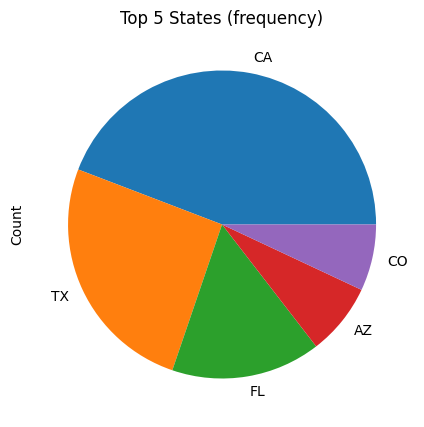

In [11]:
from pandas._libs.interval import VALID_CLOSED
# 2. Visualization (Part-to-Whole)
# #TODO: Create a pie chart visualizing the top 5 states from Question 1.
ax1 = top5_states.plot.pie(figsize=(5, 5))
ax1.set_title('Top 5 States (frequency)')
ax1.set_ylabel('Count')

Text(0, 0.5, 'Population Density mi$^2$')

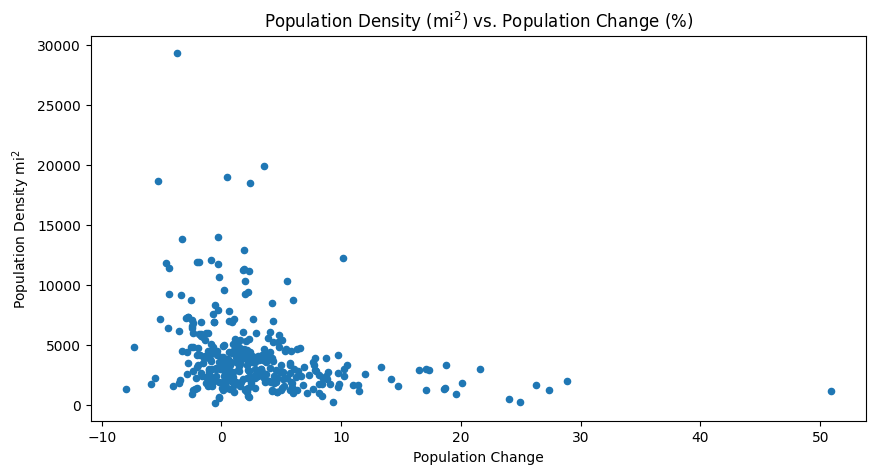

In [12]:
# 3. Correlation Analysis
# - Create a scatter plot comparing Population Density vs. Population Change.

# #TODO: Create the scatter plot
ax2 = census_table.plot.scatter(x='Change', y='2020 density / mi2', figsize=(10, 5))
ax2.set_title('Population Density (mi$^2$) vs. Population Change (%)')
ax2.set_xlabel('Population Change')
ax2.set_ylabel('Population Density mi$^2$')

   * **Question:** Do dense cities appear to be growing faster or slower than sparse cities? Discuss your observation in a text cell.

> **Answer:**
>Based on the scatter plot, dense cities appear to be growing slower than sparse cities. Cities with a smaller density tend to have the highest population growth.
>

/tmp/ipython-input-1535528742.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_population_per_state = census_table.groupby('ST')['2020 census'].sum()


Text(0, 0.5, 'Total Population of Major Cities')

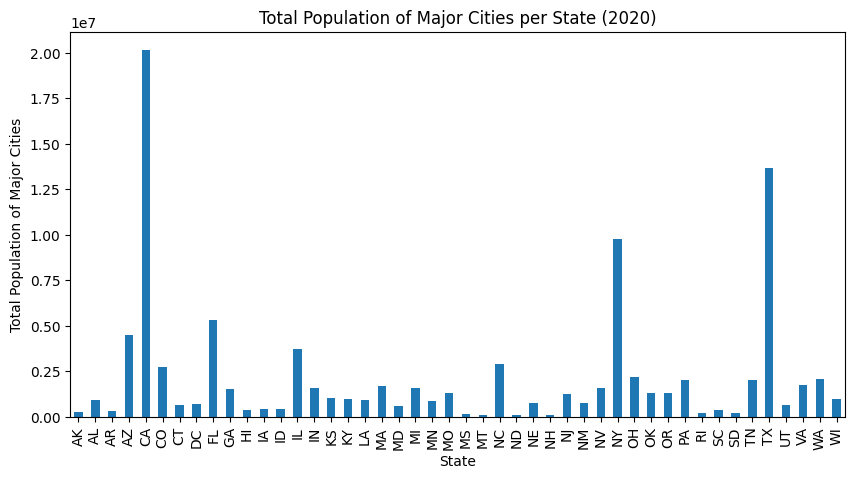

In [13]:
# 4. Aggregation
# - Compute the total population of these major cities per state.
# - Visualize this as a bar graph.
# Constraint: You MUST use the groupby function. DO NOT use a for loop.

# #TODO: Group by state, sum population, and plot bar graph
total_population_per_state = census_table.groupby('ST')['2020 census'].sum()
ax3 = total_population_per_state.plot.bar(figsize=(10, 5))
ax3.set_title('Total Population of Major Cities per State (2020)')
ax3.set_xlabel('State')
ax3.set_ylabel('Total Population of Major Cities')